[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/GANs/blob/master/gan.ipynb)

In [1]:
!pip install torch
!pip install torchvision

In [0]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torchvision
from torch import nn,optim
from  torch.utils.data import DataLoader
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [0]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=datasets.MNIST('drive/app',train=True,download=True,transform=transform)
trainloader=DataLoader(trainset,batch_size=64,shuffle=True,num_workers=2)

In [0]:
class discriminator(nn.Module):
  def __init__(self,inputsize):
    super(discriminator,self).__init__()
    self.layers=nn.Sequential(
                     nn.Linear(inputsize,512),
                     nn.LeakyReLU(0.1),
                     nn.Dropout(),
                     nn.Linear(512,256),
                     nn.LeakyReLU(0.1),
                     nn.Dropout(),
                     nn.Linear(256,64),
                     nn.LeakyReLU(0.1),
                     nn.Dropout(),
                     nn.Linear(64,1),
                     nn.Sigmoid()
    )
    
  def forward(self,data):
      return self.layers(data)
    
class generator(nn.Module):
  def __init__(self,latentsize,outputsize):
    super(generator,self).__init__()
    self.genlayer=nn.Sequential(
                         nn.Linear(latentsize,256),
                         nn.LeakyReLU(0.1),
                         nn.Linear(256,512),
                         nn.LeakyReLU(0.1),
                         nn.Linear(512,1024),
                         nn.LeakyReLU(0.1),
                         nn.Linear(1024,outputsize),
                         nn.Tanh(),
      )
  def forward(self,data):
    return self.genlayer(data)
  
imagesize=28*28
latentsize=100
num_epoch=100
lr=0.001
dis=discriminator(imagesize)
gen=generator(latentsize,imagesize)
doptimizer=optim.Adam(dis.parameters(),lr=lr)
goptimizer=optim.Adam(gen.parameters(),lr=lr)
criterion=nn.BCELoss()

In [0]:
def image_to_linear(image):
  return image.view(image.size()[0],-1)
def linear_to_image(image):
  return image.view(image.size()[0],1,28,28)
def noisegeneration(size):
  return torch.randn(size,100)
def targetone(size):
  return torch.ones(size,1)
def targetzeros(size):
  return torch.zeros(size,1)
def show_img(image):
  image=image/2+0.5
  untransform=transforms.ToPILImage()
  image=untransform(image)
  plt.imshow(image)

In [0]:
def traindis(realdata,fakedata):
  size=realdata.size()[0]
  doptimizer.zero_grad()
  real_output=dis(realdata)
  real_loss=criterion(real_output,targetone(size))
  real_loss.backward()
  
  fake_output=dis(fakedata)
  fake_loss=criterion(fake_output,targetzeros(size))
  fake_loss.backward()
  
  doptimizer.step()
  return real_loss+fake_loss
  
  
def traingen(fakedata):
  size=fakedata.size()[0]
  goptimizer.zero_grad()
  fakepasstodis=dis(fakedata)
  loss=criterion(fakepasstodis,targetone(size))
  loss.backward()
  goptimizer.step()
  return loss

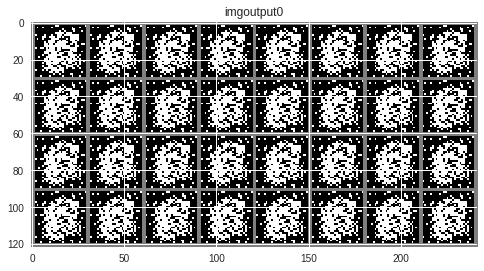

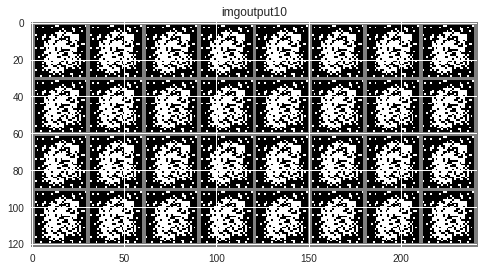

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7faedba1a0b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

RuntimeError: ignored

In [38]:
disloss=[]
genloss=[]
for i in range(num_epoch):
  for data,_ in trainloader:
    batchsize=data.size()[0]
   
    real_image=image_to_linear(data)
    fake_image=gen(noisegeneration(batchsize))
    genloss.append(traindis(real_image,fake_image))
    
    newfake_image=gen(noisegeneration(batchsize).requires_grad_())
    genloss.append(traingen(newfake_image))
  if i%10==0:
    plt.figure()
    plt.title('imgoutput{}'.format(i))
    show_img(torchvision.utils.make_grid(linear_to_image(newfake_image)))
    plt.show()

In [0]:
plt.figure()
plt.title("Discriminator loss")
plt.plot(disloss)
plt.show()
plt.figure()
plt.title("Generator loss")
plt.plot(genloss)
plt.show()